In [117]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import os, sys

In [170]:
tides = True
kl10 = True
cross_slope = True
tracer_release = False

suffix = ""
if tides:
    suffix = suffix+"-tides"
if kl10:
    suffix = suffix+"-KL10"
if cross_slope:
    suffix = suffix+"y"
if tracer_release:
    suffix = suffix+"-tracer"

input_path = f"../../MITgcm/experiments/rotated_BLT_canyon{suffix}/input/"
print(input_path)
if ~os.path.exists("/".join(input_path.split("/")[0:-2])):
    os.system(f"mkdir -p {input_path}")

../../MITgcm/experiments/rotated_BLT_canyon-tides-KL10y/input/


In [171]:
# Release location
dye_loc = [-11.885, 54.21]

## Physical parameters

In [172]:
# environmental parameters
N = 3e-3

ϕ = np.deg2rad(dye_loc[1])
f = 4*np.pi/86400.*np.sin(ϕ)
print(f"f = {f}")

gravity = 9.81
tAlpha = 2.e-4

# grid param
nx = 240
ny = 100
nz = 250

dx = 80
dy = 80
dz0 = 3
nz_vary_frac = 0.65

Lx = nx*dx
Ly = ny*dy
print(f"Lx = {Lx*1e-3}, Ly = {Ly*1e-3}")

# mixing parameters
d = 230
k0 = 5.2e-5
k1 = 1.8e-3

f = 0.00011797929793771868
Lx = 19.2, Ly = 8.0


## BBTRE Topography

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 264)
Coordinates:
  * lon      (lon) float64 -12.5 -12.49 -12.49 -12.49 ... -11.41 -11.41 -11.4
  * lat      (lat) float64 54.1 54.11 54.11 54.11 ... 54.39 54.39 54.39 54.4
    X        (lon) float64 0.0 270.9 541.9 ... 7.072e+04 7.099e+04 7.126e+04
    Y        (lat) float64 0.0 463.3 926.6 ... 3.197e+04 3.243e+04 3.29e+04
Data variables:
    z        (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    title:        Produced by grdmath
    history:      grdmath SRTM15+V2.1_land_masked.nc debug/polished.unmasked....
    GMT_version:  6.0.0 [64-bit]
    node_offset:  1

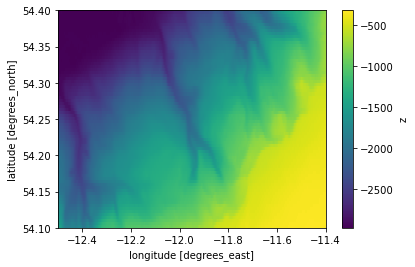

In [173]:
ds = xr.open_dataset("../../data/Tozer2019_bathymetry.nc")
ds = ds.sel(lon=slice(-12.5,-11.4), lat=slice(54.1,54.4))

R = 6.371e6
circ = 2.*np.pi*R

ds = ds.assign_coords({
    'X': (ds['lon'] - ds['lon'].isel(lon=0)) * circ/360. * np.cos(np.deg2rad(ds['lat'].sel(lat=dye_loc[1], method='nearest'))),
    'Y': (ds['lat'] - ds['lat'].isel(lat=0)) * circ/360.
})
ds['z'].plot()
ds.to_netcdf(input_path+"geocoords_original.nc")

ds

<ipython-input-174-5285ca60f03c>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lon, lat, dep)
<ipython-input-174-5285ca60f03c>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(lon, lat, dep, colors="k", levels=np.arange(-3000, 0, 250), linewidth=0.5, alpha=0.2, linestyles="solid")


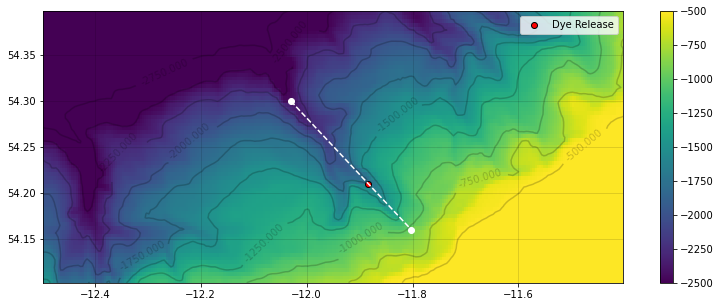

In [174]:
lon = ds["lon"].values.squeeze()
lat = ds["lat"].values.squeeze()
dep = ds["z"].values.squeeze()

plt.figure(figsize=(13, 5))
dye_loc = [-11.885, 54.21]

plt.pcolor(lon, lat, dep)
plt.colorbar()
plt.clim(-2500, -500)
CS = plt.contour(lon, lat, dep, colors="k", levels=np.arange(-3000, 0, 250), linewidth=0.5, alpha=0.2, linestyles="solid")
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.plot(dye_loc[0], dye_loc[1], "ro", label="Dye Release", markeredgecolor="k")
plt.legend()
plt.grid(True, color="k", alpha=0.15)

lats_deg = [54.3, 54.16]; lons_deg = [-12.03, -11.8025]
plt.plot(lons_deg, lats_deg, 'wo--')

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xarray/plot/plot.py:932: UserWarning: The following kwargs were not used by contour: 'linewidth'
  primitive = ax.contour(x, y, z, **kwargs)


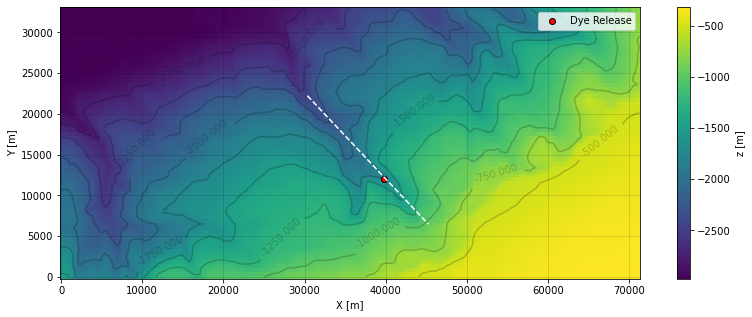

In [175]:
plt.figure(figsize=(13, 5))

ax = plt.subplot(1,1,1)
lats_dist = ds['Y'].sel(lat=lats_deg, method='nearest')
lons_dist = ds['X'].sel(lon=lons_deg, method='nearest')

dye_loc_xy = [ds['X'].sel(lon=[dye_loc[0]], method='nearest'), ds['Y'].sel(lat=[dye_loc[1]], method='nearest')]
plt.plot(dye_loc_xy[0], dye_loc_xy[1], "ro", label="Dye Release", markeredgecolor="k")

q = ds['z'].plot(x='X', y='Y')
q.colorbar.set_label('z [m]')
CS = ds['z'].plot.contour(x="X", y="Y", ax=ax, colors="k", levels=np.arange(-3000, 0, 250), linewidth=0.5, alpha=0.2, linestyles="solid")
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.plot(lons_dist, lats_dist, 'w--')

plt.legend()
plt.grid(True, color="k", alpha=0.15)

#### Rotate into along-canyon and cross-canyon coordinates

In [176]:
canyon_angle = np.arctan(np.diff(lats_dist)/np.diff(lons_dist))

In [177]:
Xr_1d = np.arange(0., Lx, dx)[np.newaxis,:]
Yr_1d = np.arange(0., Ly, dy)[:,np.newaxis]

#### Interpolate onto subdomain with new rotated coordinate frame

In [178]:
X = xr.DataArray(
    data = Xr_1d*np.cos(canyon_angle) - Yr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)
Y = xr.DataArray(
    data = Yr_1d*np.cos(canyon_angle) + Xr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)

<xarray.Dataset>
Dimensions:  (Xr: 240, Yr: 100)
Coordinates:
    lon      (Yr, Xr) float64 -12.08 -12.08 -12.07 ... -11.79 -11.79 -11.79
    lat      (Yr, Xr) float64 54.28 54.28 54.28 54.28 ... 54.2 54.2 54.2 54.2
    X        float64 3.035e+04
    Y        float64 2.224e+04
  * Yr       (Yr) float64 0.0 80.0 160.0 240.0 ... 7.76e+03 7.84e+03 7.92e+03
  * Xr       (Xr) float64 0.0 80.0 160.0 240.0 ... 1.896e+04 1.904e+04 1.912e+04
Data variables:
    z        (Yr, Xr) float64 -1.902e+03 -1.897e+03 -1.893e+03 ... -993.2 -988.8

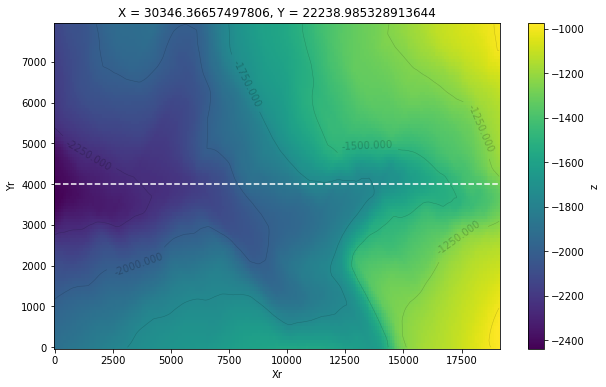

In [179]:
newds = xr.Dataset()
Δx = (Ly/2)*np.sin(canyon_angle)
Δy = -(Ly/2)*np.cos(canyon_angle)
newds['z'] = (
    ds['z']
    .swap_dims({'lon':'X', 'lat':'Y'})
    .interp(X=X+lons_dist[0]+Δx, Y=Y+lats_dist[0]+Δy)
)

plt.figure(figsize=(10,6))
newds['z'].plot()
CS = newds['z'].plot.contour(colors="k", levels=np.arange(-3000, 0, 250), linewidths=0.5, alpha=0.2, linestyles="solid")
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.plot(newds['Xr'], 0.*newds['Xr'] + Ly*0.5, "w--")
newds

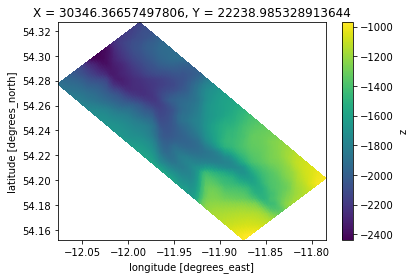

In [180]:
newds['z'].plot(x='lon', y='lat')

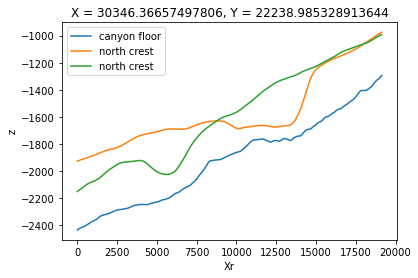

In [181]:
newds['z'].sel(Yr=Ly/2, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=slice(0, 10)).mean("Yr").plot(label='north crest')
newds['z'].isel(Yr=slice(-10, None)).mean("Yr").plot(label='north crest')
plt.legend()

#### Remove (and record) mean slope of canyon

In [182]:
slopeAngle, b = np.polyfit(newds['Xr'], newds['z'].isel(Yr=slice(ny//2-10,ny//2+10)).mean(dim="Yr"), deg=1)
print(f"θ = {slopeAngle}")

newds['z_slope'] = slopeAngle * newds['Xr'] + b

newds['z_with_slope'] = newds['z'].copy()
newds['z'] = newds['z'] - newds['z_slope']

θ = 0.057524119356765


#### Smooth topography near periodic boundaries

In [183]:
nx_smooth = 7
for i in range(nx_smooth):
    newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2+i)}] = (
        newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2)}] +
        i/nx_smooth*(
            newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2+nx_smooth)}] -
            newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2)}]
        )
    )
    
ny_smooth = 11
for j in range(ny_smooth):
    newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2+j)}] = (
        newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2)}] +
        j/ny_smooth*(
            newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2+ny_smooth)}] -
            newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2)}]
        )
    )

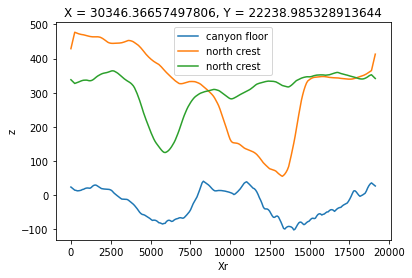

In [184]:
newds['z'].sel(Yr=Ly//2, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=slice(0, 10)).mean("Yr").plot(label='north crest')
newds['z'].isel(Yr=slice(-10, None)).mean("Yr").plot(label='north crest')

plt.legend()

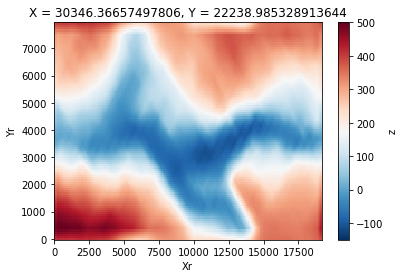

In [185]:
q = newds['z'].plot()
q.set_clim([-150, 500])

#### Stretched vertical grid

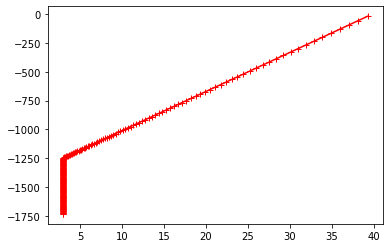

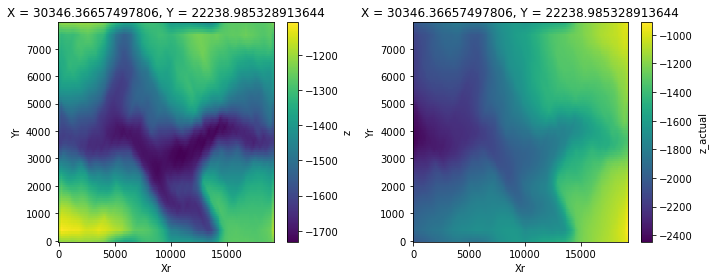

In [186]:
nz_vary = np.int(nz*nz_vary_frac)
dz = dz0 * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
dz[nz_vary:,:,:] = dz[nz_vary,0,0]*1.03**np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
Hz = sum(dz[:,0,0])

x = np.arange(dx/2.0,Lx,dx)[np.newaxis,np.newaxis,:]*np.ones((nz,ny,nx))
y = np.arange(dy/2.0,Ly,dy)[np.newaxis,:,np.newaxis]*np.ones((nz,ny,nx))
z = (-Hz + np.cumsum(dz,axis=0) - dz/2.0)

min_elv = newds['z'].min().values # minimum elevation
Hbot = newds['z'] - min_elv - (Hz - dz0)
Hremoved = newds['z_slope'] + min_elv
newds['z_actual'] = newds['z'] + newds['z_slope']

plt.figure()
plt.plot(dz[:,0,0],z[:,0,0],"r-+")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
Hbot.plot()
plt.subplot(1,2,2)
newds['z_actual'].plot()
plt.tight_layout()

newds.attrs['min_elv'] = min_elv
newds.attrs['Hz'] = Hz
newds.attrs['dz0'] = dz0

#### Initial conditions

In [187]:
gamma = (N**2)/(gravity*tAlpha)
gamma_eps = gamma*1.e-4

U = np.zeros((nz, ny, nx))
V = np.zeros((nz, ny, nx))

T = np.zeros((nz, ny, nx))
R = np.copy(T)
T += np.random.normal(size=(nz, ny, nx),scale=2.e-8)/(gravity*tAlpha) # Callies2018 initial perturbation

print("Temperature Lapse Rate is: "+np.str((N**2)/(gravity*tAlpha)))

Temperature Lapse Rate is: 0.004587155963302752


#### Forcing

In [188]:
# generate 3D vertical eddy diffusivity field
K = np.zeros((nz,ny,nx))
for i in range(nx):
    for j in range(ny):
        if kl10:
            K[:, j, i] = k0
        else:
            K[:, j, i] = k0 + k1*np.exp(-(z[:,0,0] - Hbot[j,i].values)/d)

if kl10:
    K[K>(k1+k0)] = k0
else:
    K[K>(k1+k0)] = k1+k0

In [189]:
newds = newds.assign_coords({'Z': z[:,0,0]})
newds['K'] = xr.DataArray(
    K, coords={'Z': newds['Z'], 'Yr': newds['Yr'], 'Xr': newds['Xr']}, dims=['Z', 'Yr', 'Xr']
)

### Tracers

In [190]:
# δz = 40.
# δx = 0.5e4
# δy = 0.5e4
# dye_loc[0] = -18.3; lon2 = dye_loc[0]; lon3 = dye_loc[0]; 
# dye_loc[1] = -21.7; lat2 = dye_loc[1]; lat3 = dye_loc[1];

# xy_inj = np.sqrt((Hbot['lon'] - dye_loc[0])**2 + (Hbot['lat'] - dye_loc[1])**2).argmin()
# ij = xy_inj.values
# i = ij//Hbot.shape[1]
# j = (ij-i*Hbot.shape[1])%Hbot.shape[0]

# x1 = Hbot['Xr'].isel(Xr = i).values; x2 = x1; x3 = x1;
# y1 = Hbot['Yr'].isel(Yr = j).values; y2 = y1; y3 = y1
# z1 = (Hbot.isel(Xr = i, Yr = j) + 1050.).values
# z2 = (Hbot.isel(Xr = i, Yr = j) + 600.).values
# z3 = (Hbot.isel(Xr = i, Yr = j) + 150.).values

# C1 = np.exp(- ((x - x1)/δx)**2 - ((y - y1)/δy)**2 - ((z - z1)/δz)**2)
# C2 = np.exp(- ((x - x2)/δx)**2 - ((y - y2)/δy)**2 - ((z - z2)/δz)**2)
# C3 = np.exp(- ((x - x3)/δx)**2 - ((y - y3)/δy)**2 - ((z - z3)/δz)**2)

In [191]:
# Clabels = ['BBTRE', 'Crest', 'Bottom']
# for Clabel, C in zip(Clabels, [C1, C2, C3]):
#     newds[Clabel] = xr.DataArray(
#         C, coords={'Z': newds['Z'], 'Yr': newds['Yr'], 'Xr': newds['Xr']}, dims=['Z', 'Yr', 'Xr']
#     )

In [192]:
newds.to_netcdf(input_path+"geocoords.nc")

## Configuration summary plot

<ipython-input-193-c0988c6e470b>:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s="Release", xy=(dye_loc[0]+0.012, dye_loc[1]-0.0015), horizontalalignment="left", verticalalignment="center", fontsize=16, color="w")
<ipython-input-193-c0988c6e470b>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  q = plt.pcolor(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values,K[:,sec_j,:], norm=matplotlib.colors.LogNorm(vmin=5.e-5, vmax=2.e-3), cmap="plasma")


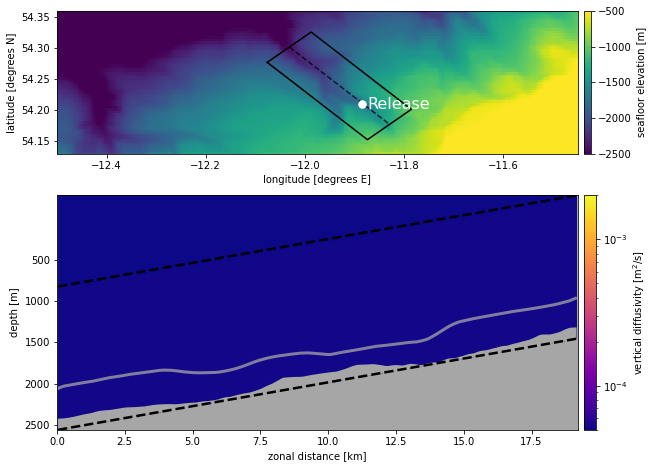

In [193]:
sec_j = ny//2

Hoffset = Hremoved + (Hz-dz0)

scale_fig = 0.6
fig = plt.figure(figsize=(16*scale_fig,11*scale_fig))
gs = fig.add_gridspec(5, 1)

f_ax1 = fig.add_subplot(gs[:2, :])
q = ds['z'].plot.pcolormesh(x='lon', y='lat')
plt.fill_between([-25, -10], [-30, -30], [0, 0], facecolor="w", alpha=0.20)
q.set_rasterized(True)
q.set_clim([-2500, -500])
q.colorbar.remove()
q = (newds['z_actual']).plot(x='lon', y='lat')
q.set_clim([-2500, -500])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, label=r"seafloor elevation [m]")
plt.plot([newds['lon'].isel(Xr=0, Yr=sec_j), newds['lon'].isel(Xr=-1, Yr=sec_j)], [newds['lat'].isel(Xr=0, Yr=sec_j), newds['lat'].isel(Xr=-1, Yr=sec_j)], "k--", alpha=0.75)

plt.plot(dye_loc[0], dye_loc[1], "wo", markersize=7.5)
plt.annotate(s="Release", xy=(dye_loc[0]+0.012, dye_loc[1]-0.0015), horizontalalignment="left", verticalalignment="center", fontsize=16, color="w")

plt.plot(
    [newds['lon'].isel(Xr=0, Yr=0), newds['lon'].isel(Xr=0, Yr=-1), newds['lon'].isel(Xr=-1, Yr=-1), newds['lon'].isel(Xr=-1, Yr=0), newds['lon'].isel(Xr=0, Yr=0)],
    [newds['lat'].isel(Xr=0, Yr=0), newds['lat'].isel(Xr=0, Yr=-1), newds['lat'].isel(Xr=-1, Yr=-1), newds['lat'].isel(Xr=-1, Yr=0), newds['lat'].isel(Xr=0, Yr=0)],
    "k-"
)

X0 = newds['lon'].isel(Xr=0, Yr=0);
Xx = newds['lon'].isel(Xr=-1, Yr=0);
Xy = newds['lon'].isel(Xr=0, Yr=-1);
Y0 = newds['lat'].isel(Xr=0, Yr=0);
Yx = newds['lat'].isel(Xr=-1, Yr=0);
Yy = newds['lat'].isel(Xr=0, Yr=-1)
# Xa = -14.5; Ya = -22.05;
# plt.arrow(Xa, Ya, (Xx-X0)*0.09, (Yx-Y0)*0.09, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
# plt.arrow(Xa, Ya, (Xy-X0)*0.67, (Yy-Y0)*0.67, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
# plt.annotate(s=r"$x$", xy=(Xa+0.425, Ya-0.11), fontsize=18)
# plt.annotate(s=r"$y$", xy=(Xa-0.25, Ya+0.365), fontsize=18)
plt.title("")
plt.xlabel("longitude [degrees E]")
plt.ylabel("latitude [degrees N]")

plt.xlim([-12.5, -11.45])
plt.ylim([54.13, 54.36])

nancol = (0.65,0.65,0.65)
f_ax1 = fig.add_subplot(gs[2:, :], facecolor=nancol)
q = plt.pcolor(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values,K[:,sec_j,:], norm=matplotlib.colors.LogNorm(vmin=5.e-5, vmax=2.e-3), cmap="plasma")
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar(q, pad=0.01, label=r"vertical diffusivity [m$^{2}$/s]")
plt.fill_between(x[0,0,:]*1e-3, Hremoved - 10, Hbot[sec_j,:]+Hoffset, facecolor=nancol)
plt.fill_between(x[0,0,:]*1e-3, Hremoved + (Hz-50.), np.zeros_like(x[0,0,:])+Hz, facecolor=cm.plasma(0.))

plt.plot(x[0,0,:]*1e-3, Hremoved, "k--", lw=2.5)
plt.plot(x[0,0,:]*1e-3, Hremoved+(Hz-dz0), "k--", lw=2.5)
plt.plot(Hbot['Xr']*1e-3, (Hbot+Hoffset).isel(Yr=np.append(np.arange(-10,0), np.arange(0,10))).mean(dim='Yr'), color=nancol, lw=3.0, alpha=0.75)

# plt.contour(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values, C1[:,ny//2,:], levels=[0.37], colors="w", linewidths=2.5)
# plt.contour(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values, C2[:,ny//2,:], levels=[0.37], colors="w", linewidths=2.5)
# plt.contour(x[:,0,:]*1e-3, z[:,0,:]+Hoffset.values, C3[:,ny//2,:], levels=[0.37], colors="w", linewidths=2.5)

# plt.annotate(s="Realistic Release", xy=(40, -4150), color="w", fontsize=13, weight="bold")
# plt.annotate(s="Crest Release", xy=(40, -4600), color="w", fontsize=13, weight="bold")
# plt.annotate(s="Bottom Release", xy=(40, -5050), color="w", fontsize=13, weight="bold")
# plt.annotate(s="DoMORE sill", xy=(385, -3250), color="w", fontsize=13, weight="bold")

plt.yticks(np.arange(-5000, -0, 500), np.arange(5000, 0, -500))

plt.xlim([0, Lx*1e-3])
plt.ylim([Hremoved.min(), (Hremoved + (Hz-dz0)).max()])

plt.tight_layout()

#### Write init files

In [194]:
# Reverse vertical axis so first index is at the surface and transpose axes
U = U[::-1,:,:]
V = V[::-1,:,:]
T = T[::-1,:,:]
R = R[::-1,:1,:1]
K = K[::-1,:,:]

# C1 = C1[::-1,:,:]
# C2 = C2[::-1,:,:]
# C3 = C3[::-1,:,:]
dz = dz[::-1,:1,:1]

# save input data as binary files
newFile = open(input_path+"U.init", "wb")
newFile.write(bytes(U.astype('>f8')))
newFile.close()

newFile = open(input_path+"V.init", "wb")
newFile.write(bytes(V.astype('>f8')))
newFile.close()

newFile = open(input_path+"T.init", "wb")
newFile.write(bytes(T.astype('>f8')))
newFile.close()

np.savetxt(input_path+"R.init", R[:,0,0], encoding="-ascii", fmt='%.7e', newline="\n   ")

newFile = open(input_path+"kappa.init", "wb")
newFile.write(bytes(K.astype('>f8')))
newFile.close()

# newFile = open(input_path+"cBBTRE.init", "wb")
# newFile.write(bytes(C1.astype('>f8')))
# newFile.close()

# newFile = open(input_path+"cCrest.init", "wb")
# newFile.write(bytes(C2.astype('>f8')))
# newFile.close()

# newFile = open(input_path+"cBottom.init", "wb")
# newFile.write(bytes(C3.astype('>f8')))
# newFile.close()

newFile = open(input_path+"topog.init", "wb")
newFile.write(bytes(Hbot[:,:].values.astype('>f8')))
newFile.close()

newFile = open(input_path+"delZ.init", "wb")
newFile.write(bytes(dz[:,0,0].astype('>f8')))
newFile.close()

In [195]:
import os
os.system(f"cp ./gendata_BLT_canyon.ipynb {input_path}");